In [1]:
import pandas as pd
import numpy as np
import itertools
import lightgbm as lgbm
import matplotlib.pyplot as plt

from script import *
from feature_engineering import *
import db_operations as dbop
from constants import *
import data_process as dp

import time

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
pd.set_option('display.max_rows',200)
idx = pd.IndexSlice
agg_operations =['mean','median','max','min','std','size']

In [3]:
%time df = pd.read_hdf(os.path.join('datasets','df_20140101.h5'),key='data')
df = df.sort_index()
df.shape
df.columns

Wall time: 11.6 s


(4593560, 64)

Index(['open', 'high', 'low', 'close', 'vol', 'amt', 'adj_factor', 'avg',
       'close0', 'avg0', 'pct', 'turnover_rate', 'turnover_rate_f',
       'volume_ratio', 'pe', 'pe_ttm', 'pb', 'ps', 'ps_ttm', 'total_share',
       'float_share', 'free_share', 'total_mv', 'circ_mv', 'pb*pe_ttm',
       'pb*pe', '5ma', '10ma', '20ma', '40ma', '60ma', '120ma', '250ma',
       'close/5ma', 'close/10ma', 'close/20ma', 'close/40ma', 'close/60ma',
       'close/120ma', 'close/250ma', '60ma_pct', '20ma_pct', 'p5max_abs_pct',
       'p10max_abs_pct', '30ma', '30ma_pct', 'close/30ma', 'prev_close',
       'day_pct', 'close0_rank', 'close0_pct', 'prev_pct', 'prev_day_pct',
       'sell_at', 'sell_at0', 'sell_date', 'sell_idx', 'buy_at', 'buy_at0',
       'max', 'max_idx', 'idx', 'is_selled', 'r'],
      dtype='object')

In [4]:
mask_date = df.index.get_level_values('date')>='2016-01-01'
df_baseline = df.loc[mask_date,'r'].agg(agg_operations[:-1])
df_baseline_q = df.loc[mask_date,'r'].reset_index('code').resample('Q').agg(agg_operations)
df_baseline
df_baseline_q

mean     -0.003319
median   -0.021764
max       5.543209
min      -0.972953
std       0.094291
Name: r, dtype: float64

r                                                
                mean    median       max       min       std    size
date                                                                
2016-03-31  0.001993 -0.018907  3.210775 -0.972953  0.106063  150433
2016-06-30  0.001559 -0.020861  1.944000 -0.714186  0.094675  155157
2016-09-30  0.007954 -0.008368  2.405940 -0.651400  0.083539  170115
2016-12-31 -0.007982 -0.018912  2.487285 -0.900237  0.071205  165772
2017-03-31  0.000778 -0.012563  1.463308 -0.482470  0.076877  170618
2017-06-30 -0.013874 -0.030237  5.543209 -0.852388  0.088826  178502
2017-09-30  0.007274 -0.008121  1.925995 -0.804020  0.080761  200686
2017-12-31 -0.021151 -0.031991  1.990148 -0.814664  0.063842  193463
2018-03-31 -0.013712 -0.029727  1.814716 -0.967228  0.089663  190955
2018-06-30 -0.027349 -0.036075  1.174034 -0.950667  0.068656  197214
2018-09-30 -0.026512 -0.033389  1.554622 -0.869820  0.057996  218246
2018-12-31  0.002983 -0.020253  2.526171 -0.612903  0.094861  210707
2019-03-31  0.065352  0.012469  2.550678 -0.746753  0.163316  206870
2019-06-30 -0.015648 -0.027737  2.430079 -0.861940  0.070399  215321
2019-09-30 -0.000834 -0.021739  2.231214 -0.876993  0.084032  236958
2019-12-31  0.009239 -0.009906  2.763278 -0.731959  0.107321  225939
2020-03-31 -0.018712 -0.030406  2.382353 -0.763889  0.113561  218582
2020-06-30 -0.015541 -0.027642  1.050950 -0.787500  0.063938  148256

In [7]:
mask_basic =[   
    # 流动性、市值等基本限制 
#     mean     -2.309262e-03
#     median   -1.832455e-02
#     size   2373852
    df['amt']>=2,
    df['turnover_rate']<10,
    df['circ_mv']>50e4, 
    df['total_mv']>100e4,
    df.index.get_level_values('code').str[:3]!='688',
]

mask_baseline2 = True

for m in mask_basic+[mask_date]:

    mask_baseline2 &= m
    m.sum(),len(m),round(m.sum()/len(m),4),round(mask_baseline2.sum()/len(mask_baseline2),4)


df_baseline2 = df.loc[mask_baseline2,'r'].agg(agg_operations[:-1])
df_baseline2_q = df.loc[mask_baseline2,'r'].reset_index('code').resample('Q').agg(agg_operations)
df_baseline2
df_baseline2_q

(1056950, 4593560, 0.2301, 0.2301)

(4348257, 4593560, 0.9466, 0.1915)

(2056374, 4593560, 0.4477, 0.1672)

(1433930, 4593560, 0.3122, 0.1327)

(4580262, 4593560, 0.9971, 0.1326)

(3453794, 4593560, 0.7519, 0.0855)

mean     -0.006251
median   -0.024428
max       2.568360
min      -0.900237
std       0.087799
Name: r, dtype: float64

r                                               
                mean    median       max       min       std   size
date                                                               
2016-03-31 -0.014662 -0.027145  0.726236 -0.311024  0.076614  27037
2016-06-30 -0.010104 -0.028700  1.036980 -0.350000  0.080394  25142
2016-09-30 -0.009122 -0.021322  0.866848 -0.281843  0.061336  26893
2016-12-31 -0.010028 -0.020720  0.890990 -0.900237  0.066728  22763
2017-03-31  0.001280 -0.012232  0.893928 -0.477344  0.070490  18999
2017-06-30  0.005688 -0.021420  2.568360 -0.724272  0.130106  18192
2017-09-30  0.005488 -0.016282  1.040956 -0.762918  0.084099  25330
2017-12-31 -0.008364 -0.026906  0.906878 -0.668041  0.071168  21403
2018-03-31 -0.021992 -0.033844  0.756948 -0.750282  0.071395  22051
2018-06-30 -0.024731 -0.035714  0.657955 -0.655048  0.062431  18740
2018-09-30 -0.026462 -0.035882  0.435772 -0.869820  0.057367  14113
2018-12-31 -0.015106 -0.031567  2.060041 -0.343186  0.073287  12367
2019-03-31  0.047785  0.004065  2.275248 -0.643750  0.146959  22584
2019-06-30 -0.019767 -0.031667  0.566667 -0.680233  0.066161  24785
2019-09-30 -0.001096 -0.024540  0.865332 -0.317718  0.083108  21064
2019-12-31  0.014648 -0.010989  1.704486 -0.359756  0.111326  20419
2020-03-31 -0.018133 -0.033515  1.028526 -0.301961  0.099270  32503
2020-06-30 -0.011432 -0.026504  0.630499 -0.326328  0.061965  18234

In [8]:
%time df['5ma_pct'] = df['5ma'].sort_index().groupby('code').pct_change()*100 # 7s

Wall time: 7.29 s


In [9]:
target_col = '5ma_pct'
min_periods=1

for k in [5,10,15,20,25,30]:
    %time tmp = groupby_rolling(df[target_col],level="code",window=k,ops=['mean','median','std'],min_periods=min_periods)
    df[tmp.columns] = tmp

Wall time: 21.3 s
Wall time: 16.9 s
Wall time: 17.9 s
Wall time: 21.9 s
Wall time: 25.2 s
Wall time: 22.4 s


In [31]:
# list(df.columns)

# for k in [5,10,15,20,25,30]:
# #     %time tmp = groupby_rolling(df[[target_col,'close']],level="code",window=k,ops=['mean','median','std'],min_periods=min_periods)
# #     df[tmp.columns] = tmp
#     df['p{}mean-std_5ma_pct'.format(k)] = df['p{}mean_5ma_pct'.format(k)]-df['p{}std_5ma_pct'.format(k)]
    
# list(df.columns)

# %time df_tmp = df[mask_date] # 21s
for k in [5,10,15,20,25,30]:
    print('\nk={}'.format(k))
    for p in [0.5,0.8,0.9,0.95,0.99]:
        col1 = 'p{}mean_5ma_pct'.format(k)
        col2 = 'p{}mean-std_5ma_pct'.format(k)
        '{}:{:.1%}={:.3f}'.format(col1,p,df_tmp[col1].quantile(p))
        '{}:{:.1%}={:.3f}'.format(col2,p,df_tmp[col2].quantile(p))


k=5


'p5mean_5ma_pct50.0%=-0.024'

'p5mean-std_5ma_pct50.0%=-0.550'

'p5mean_5ma_pct80.0%=0.634'

'p5mean-std_5ma_pct80.0%=0.076'

'p5mean_5ma_pct90.0%=1.094'

'p5mean-std_5ma_pct90.0%=0.427'

'p5mean_5ma_pct95.0%=1.597'

'p5mean-std_5ma_pct95.0%=0.786'

'p5mean_5ma_pct99.0%=3.250'

'p5mean-std_5ma_pct99.0%=1.866'


k=10


'p10mean_5ma_pct50.0%=-0.036'

'p10mean-std_5ma_pct50.0%=-0.743'

'p10mean_5ma_pct80.0%=0.501'

'p10mean-std_5ma_pct80.0%=-0.189'

'p10mean_5ma_pct90.0%=0.868'

'p10mean-std_5ma_pct90.0%=0.058'

'p10mean_5ma_pct95.0%=1.251'

'p10mean-std_5ma_pct95.0%=0.288'

'p10mean_5ma_pct99.0%=2.470'

'p10mean-std_5ma_pct99.0%=0.886'


k=15


'p15mean_5ma_pct50.0%=-0.040'

'p15mean-std_5ma_pct50.0%=-0.849'

'p15mean_5ma_pct80.0%=0.424'

'p15mean-std_5ma_pct80.0%=-0.329'

'p15mean_5ma_pct90.0%=0.734'

'p15mean-std_5ma_pct90.0%=-0.121'

'p15mean_5ma_pct95.0%=1.053'

'p15mean-std_5ma_pct95.0%=0.051'

'p15mean_5ma_pct99.0%=2.027'

'p15mean-std_5ma_pct99.0%=0.497'


k=20


'p20mean_5ma_pct50.0%=-0.048'

'p20mean-std_5ma_pct50.0%=-0.925'

'p20mean_5ma_pct80.0%=0.365'

'p20mean-std_5ma_pct80.0%=-0.427'

'p20mean_5ma_pct90.0%=0.640'

'p20mean-std_5ma_pct90.0%=-0.228'

'p20mean_5ma_pct95.0%=0.921'

'p20mean-std_5ma_pct95.0%=-0.082'

'p20mean_5ma_pct99.0%=1.741'

'p20mean-std_5ma_pct99.0%=0.254'


k=25


'p25mean_5ma_pct50.0%=-0.052'

'p25mean-std_5ma_pct50.0%=-0.975'

'p25mean_5ma_pct80.0%=0.325'

'p25mean-std_5ma_pct80.0%=-0.497'

'p25mean_5ma_pct90.0%=0.571'

'p25mean-std_5ma_pct90.0%=-0.308'

'p25mean_5ma_pct95.0%=0.823'

'p25mean-std_5ma_pct95.0%=-0.173'

'p25mean_5ma_pct99.0%=1.527'

'p25mean-std_5ma_pct99.0%=0.076'


k=30


'p30mean_5ma_pct50.0%=-0.054'

'p30mean-std_5ma_pct50.0%=-1.015'

'p30mean_5ma_pct80.0%=0.292'

'p30mean-std_5ma_pct80.0%=-0.551'

'p30mean_5ma_pct90.0%=0.520'

'p30mean-std_5ma_pct90.0%=-0.371'

'p30mean_5ma_pct95.0%=0.748'

'p30mean-std_5ma_pct95.0%=-0.242'

'p30mean_5ma_pct99.0%=1.373'

'p30mean-std_5ma_pct99.0%=-0.025'

In [53]:
r_columns = ['buy_at','max','max_idx', 'idx', 'is_selled', 'sell_at', 'sell_date', 'r']


mask_trend = [
    df['p15mean-std_5ma_pct'] > 0.5,
]



# mask_low_pos = [
#     df[['close/60ma','close/30ma']].min(axis=1)<1.03,
# #     df[['close/60ma','close/30ma']].max(axis=1)<1.05,
    
#     df['close/5ma']<1.03,
# #     df['close/10ma']<1.03,
# #     df['close/20ma']<1.03,
    
# #     df['close/120ma']>1.07,
# #     df['close/250ma']>1.1,
# #     df[['close/30ma','close/60ma','close/120ma','close/250ma']].max(axis=1)>0.9,
# ]

mask_low_pos = [
#     df['close/60ma']<1.125,
    df['close/60ma']<1.125,
#     df['close/30ma']<1.05,
    df['close/5ma']<1.05,
    df['close/10ma']<1.05,

#     df['close/120ma']<1.07,
    df[['close/30ma','close/60ma','close/120ma','close/250ma']].max(axis=1)>0.9,
]


mask_basic =[   
    # 流动性、市值等基本限制 
#     mean     -2.309262e-03
#     median   -1.832455e-02
#     size   2373852
    df['amt']>=2,
    df['turnover_rate']<10,
    df['circ_mv']>50e4, 
    df['total_mv']>100e4,
    
#     (df['pb']<10) | (df['pe']>0),
    
    
#     df['close0']>5,
#     df['close0_rank']<100,
#     df['close0_rank']>10,
#     df['close0_pct']<0.015,
#     df['close0_pct']>0.01,

    df.index.get_level_values('code').str[:3]!='688',
]



mask_final = True
# masks = mask_big_rise+mask_basic+mask_trend
masks = mask_trend+mask_low_pos+mask_basic
# masks = mask_shrink_amt+mask_trend+mask_basic


for m in masks+[mask_date]:

    mask_final &= m
    m.sum(),len(m),round(m.sum()/len(m),4),round(mask_final.sum()/len(mask_final),4)

# df_baseline
# df_baseline_q


df.loc[mask_final,'r'].agg(agg_operations)
df.loc[mask_final,'r'].reset_index('code').resample('Q').agg(agg_operations)
# df.loc[mask_final,'r'].reset_index('code').groupby('date').agg(agg_operations)

tmp = df.loc[mask_final,r_columns].sort_values('date',ascending=False)
# tmp[tmp['r'].notnull()].iloc[len(tmp)//2:len(tmp)//2+50]
tmp.sort_values('date').tail(70)
tmp.sort_values('date').iloc[-1000:-950]

(65157, 4593560, 0.0142, 0.0142)

(3289898, 4593560, 0.7162, 0.0014)

(4260136, 4593560, 0.9274, 0.0014)

(3918805, 4593560, 0.8531, 0.001)

(4110067, 4593560, 0.8947, 0.001)

(1056950, 4593560, 0.2301, 0.0002)

(4348257, 4593560, 0.9466, 0.0002)

(2056374, 4593560, 0.4477, 0.0002)

(1433930, 4593560, 0.3122, 0.0001)

(4580262, 4593560, 0.9971, 0.0001)

(3453794, 4593560, 0.7519, 0.0001)

mean        0.007027
median     -0.016070
max         0.745222
min        -0.179823
std         0.117144
size      358.000000
Name: r, dtype: float64

r                                             
                mean    median       max       min       std size
date                                                             
2016-03-31 -0.013237 -0.009479  0.220253 -0.124339  0.076494   20
2016-06-30 -0.031794 -0.036667  0.115527 -0.128713  0.077548   10
2016-09-30  0.001609 -0.008088  0.184009 -0.059204  0.062561   15
2016-12-31 -0.020850 -0.019313  0.003096 -0.056494  0.022023    5
2017-03-31 -0.015455 -0.008704  0.008257 -0.048571  0.019567    7
2017-06-30 -0.009440  0.006337  0.024641 -0.100518  0.040904   11
2017-09-30  0.015623 -0.014844  0.206394 -0.046725  0.085911    8
2017-12-31 -0.026294 -0.024706 -0.012305 -0.041870  0.014846    3
2018-03-31 -0.045794 -0.046358  0.178411 -0.149723  0.052649   77
2018-06-30 -0.028714 -0.029231 -0.004444 -0.056490  0.023209    7
2018-09-30 -0.022539 -0.023376  0.001955 -0.045837  0.019561    6
2018-12-31 -0.026623 -0.025941  0.018994 -0.063325  0.029124    6
2019-03-31  0.095484  0.031700  0.745222 -0.060246  0.188022   71
2019-06-30  0.017226  0.009651  0.089569 -0.039966  0.066868    4
2019-09-30 -0.011948 -0.018609  0.093220 -0.069178  0.036292   32
2019-12-31  0.012605  0.041316  0.127207 -0.120782  0.069455   27
2020-03-31  0.016297 -0.016268  0.507850 -0.179823  0.158322   27
2020-06-30  0.001282  0.017722  0.059036 -0.100865  0.055647   22

,,buy_at,max,max_idx,idx,is_selled,sell_at,sell_date,r
code,date,,,,,,,,
002008.SZ,2019-12-19,502.057098,568.547119,2409.0,2397,True,547.362183,2020-01-20,0.090239
300433.SZ,2019-12-19,81.336800,82.447205,1139.0,1138,True,78.283203,2019-12-24,-0.037543
300166.SZ,2019-12-19,250.957153,251.888016,1938.0,1937,True,236.808258,2019-12-30,-0.056380
600667.SH,2019-12-19,39.378242,39.577122,2280.0,2279,True,36.991680,2019-12-24,-0.060606
000961.SZ,2019-12-19,52.386410,60.686882,2392.0,2383,True,55.299824,2020-01-13,0.055614
002384.SZ,2019-12-19,165.007782,166.321426,2148.0,2147,True,158.001694,2019-12-24,-0.042459
002217.SZ,2019-12-19,32.518452,32.860149,2218.0,2217,True,30.639101,2019-12-24,-0.057793
000961.SZ,2019-12-20,52.771206,60.686882,2392.0,2384,True,55.299824,2020-01-13,0.047917
002217.SZ,2019-12-20,32.062851,36.846649,2241.0,2218,True,28.190250,2020-02-04,-0.120782


In [72]:
r_columns = ['buy_at','max','max_idx', 'idx', 'is_selled', 'sell_at', 'sell_date', 'r']


mask_trend = [
    df['p10mean_5ma_pct'] > 1.2,
    df['p10mean_5ma_pct'] < 2,
    df['p10mean_5ma_pct'] > 1.3 * df['p20std_5ma_pct'],
]



# mask_low_pos = [
#     df[['close/60ma','close/30ma']].min(axis=1)<1.03,
# #     df[['close/60ma','close/30ma']].max(axis=1)<1.05,
    
#     df['close/5ma']<1.03,
# #     df['close/10ma']<1.03,
# #     df['close/20ma']<1.03,
    
# #     df['close/120ma']>1.07,
# #     df['close/250ma']>1.1,
# #     df[['close/30ma','close/60ma','close/120ma','close/250ma']].max(axis=1)>0.9,
# ]

mask_low_pos = [
#     df['close/60ma']<1.125,
    df['close/60ma']<1.125,
#     df['close/30ma']<1.05,
    df['close/5ma']<1.05,
    df['close/10ma']<1.05,

#     df['close/120ma']<1.07,
    df[['close/30ma','close/60ma','close/120ma','close/250ma']].max(axis=1)>0.9,
]


mask_basic =[   
    # 流动性、市值等基本限制 
#     mean     -2.309262e-03
#     median   -1.832455e-02
#     size   2373852
    df['amt']>=2,
    df['turnover_rate']<10,
    df['circ_mv']>50e4, 
    df['total_mv']>100e4,
    
#     (df['pb']<10) | (df['pe']>0),
    
    
#     df['close0']>5,
#     df['close0_rank']<100,
#     df['close0_rank']>10,
#     df['close0_pct']<0.015,
#     df['close0_pct']>0.01,

    df.index.get_level_values('code').str[:3]!='688',
]



mask_final = True
# masks = mask_big_rise+mask_basic+mask_trend
masks = mask_trend+mask_low_pos+mask_basic
# masks = mask_shrink_amt+mask_trend+mask_basic


for m in masks+[mask_date]:

    mask_final &= m
    m.sum(),len(m),round(m.sum()/len(m),4),round(mask_final.sum()/len(mask_final),4)

# df_baseline
# df_baseline_q


df.loc[mask_final,'r'].agg(agg_operations)
df.loc[mask_final,'r'].reset_index('code').resample('Q').agg(agg_operations)
# df.loc[mask_final,'r'].reset_index('code').groupby('date').agg(agg_operations)

tmp = df.loc[mask_final,r_columns].sort_values('date',ascending=False)
# tmp[tmp['r'].notnull()].iloc[len(tmp)//2:len(tmp)//2+50]
tmp.sort_values('date').tail(70)
tmp.sort_values('date').iloc[-1000:-950]

(358192, 4593560, 0.078, 0.078)

(4434792, 4593560, 0.9654, 0.051)

(168838, 4593560, 0.0368, 0.0115)

(3289898, 4593560, 0.7162, 0.0015)

(4260136, 4593560, 0.9274, 0.0015)

(3918805, 4593560, 0.8531, 0.001)

(4110067, 4593560, 0.8947, 0.001)

(1056950, 4593560, 0.2301, 0.0003)

(4348257, 4593560, 0.9466, 0.0003)

(2056374, 4593560, 0.4477, 0.0002)

(1433930, 4593560, 0.3122, 0.0002)

(4580262, 4593560, 0.9971, 0.0002)

(3453794, 4593560, 0.7519, 0.0001)

mean        0.000901
median     -0.024784
max         0.535270
min        -0.206349
std         0.092699
size      566.000000
Name: r, dtype: float64

r                                             
                mean    median       max       min       std size
date                                                             
2016-03-31 -0.024639 -0.035984  0.142450 -0.124339  0.072152   22
2016-06-30  0.029687  0.006774  0.240055 -0.054697  0.087449   20
2016-09-30 -0.005761 -0.025841  0.206977 -0.086486  0.068344   42
2016-12-31 -0.007353 -0.012431  0.125599 -0.094766  0.063944   21
2017-03-31  0.004684 -0.012478  0.114754 -0.069697  0.057439   26
2017-06-30  0.073938 -0.013328  0.535270 -0.065421  0.189781   10
2017-09-30 -0.008719 -0.021739  0.170268 -0.143291  0.053945   37
2017-12-31  0.005693 -0.015581  0.146342 -0.084695  0.063628   26
2018-03-31 -0.030180 -0.034442  0.253521 -0.149723  0.060676   54
2018-06-30 -0.027297 -0.038003  0.118012 -0.096267  0.053192   15
2018-09-30 -0.047773 -0.048819  0.040404 -0.121474  0.038522   25
2018-12-31 -0.043991 -0.036126 -0.015038 -0.093656  0.028443    6
2019-03-31  0.093351  0.021751  0.449735 -0.052055  0.145688   62
2019-06-30 -0.013392 -0.022952  0.091437 -0.064198  0.041842   15
2019-09-30 -0.029890 -0.036252  0.277580 -0.108140  0.042146   88
2019-12-31  0.018052 -0.019708  0.334359 -0.166000  0.104241   28
2020-03-31  0.014050 -0.020029  0.384347 -0.206349  0.127955   44
2020-06-30 -0.023384 -0.036572  0.093878 -0.070423  0.047666   25

,,buy_at,max,max_idx,idx,is_selled,sell_at,sell_date,r
code,date,,,,,,,,
000723.SZ,2019-12-30,63.745533,66.091576,2125.0,2120,True,62.069782,2020-01-13,-0.026288
002078.SZ,2020-01-08,83.843903,87.302261,2400.0,2395,True,82.663002,2020-01-20,-0.014085
000975.SZ,2020-01-09,97.021194,97.298805,2107.0,2106,True,91.261002,2020-01-20,-0.059370
002155.SZ,2020-01-09,22.530388,22.557178,2359.0,2358,True,21.083729,2020-01-23,-0.064209
600893.SH,2020-01-09,75.226501,76.277702,2277.0,2276,True,71.612999,2020-01-23,-0.048035
600547.SH,2020-01-10,543.051086,547.103699,2244.0,2243,True,519.203003,2020-01-23,-0.043915
300134.SZ,2020-01-10,73.861893,75.895584,1863.0,1861,True,70.313751,2020-01-17,-0.048038
002155.SZ,2020-01-10,22.396439,22.476810,2361.0,2359,True,21.083729,2020-01-23,-0.058612
600741.SH,2020-01-13,1287.791992,1309.255249,2372.0,2369,True,1233.239746,2020-01-22,-0.042361


,,buy_at,max,max_idx,idx,is_selled,sell_at,sell_date,r
code,date,,,,,,,,


In [80]:
# df['f1_open'] = df['open'].sort_index().groupby('code').shift(-1)
# df['f2_close'] = df['close'].sort_index().groupby('code').shift(-2)
df['f2_open'] = df['open'].sort_index().groupby('code').shift(-2)

df[['open','close','f1_open','f2_open','f2_close']].tail(50)

open      close    f1_open    f2_open   f2_close
code      date                                                              
688466.SH 2020-05-20   42.990002  43.750000  43.790001  44.389999  40.849998
          2020-05-21   43.790001  44.380001  44.389999  40.900002  37.700001
          2020-05-22   44.389999  40.849998  40.900002  37.700001  38.500000
          2020-05-25   40.900002  37.700001  37.700001  38.560001  38.919998
          2020-05-26   37.700001  38.500000  38.560001  39.000000  37.980000
          2020-05-27   38.560001  38.919998  39.000000  37.980000  39.360001
          2020-05-28   39.000000  37.980000  37.980000        NaN        NaN
          2020-05-29   37.980000  39.360001        NaN        NaN        NaN
688516.SH 2020-05-21   55.020000  62.200001  61.599998  64.199997  56.680000
          2020-05-22   61.599998  64.300003  64.199997  55.500000  61.160000
          2020-05-25   64.199997  56.680000  55.500000  59.270000  58.889999
          2020-05-26   55.500000  61.160000  59.270000  58.310001  56.400002
          2020-05-27   59.270000  58.889999  58.310001  55.500000  53.980000
          2020-05-28   58.310001  56.400002  55.500000        NaN        NaN
          2020-05-29   55.500000  53.980000        NaN        NaN        NaN
688566.SH 2020-05-18   49.500000  45.700001  45.599998  53.599998  52.020000
          2020-05-19   45.599998  54.799999  53.599998  51.099998  49.189999
          2020-05-20   53.599998  52.020000  51.099998  49.049999  45.599998
          2020-05-21   51.099998  49.189999  49.049999  45.759998  43.169998
          2020-05-22   49.049999  45.599998  45.759998  42.990002  44.750000
          2020-05-25   45.759998  43.169998  42.990002  44.380001  45.139999
          2020-05-26   42.990002  44.750000  44.380001  44.299999  43.169998
          2020-05-27   44.380001  45.139999  44.299999  43.000000  42.990002
          2020-05-28   44.299999  43.169998  43.000000        NaN        NaN
          2020-05-29   43.000000  42.990002        NaN        NaN        NaN
688588.SH 2020-05-11   48.000000  41.930000  39.099998  40.119999  48.590000
          2020-05-12   39.099998  40.959999  40.119999  46.889999  46.580002
          2020-05-13   40.119999  48.590000  46.889999  46.040001  49.720001
          2020-05-14   46.889999  46.580002  46.040001  48.000000  45.520000
          2020-05-15   46.040001  49.720001  48.000000  45.599998  47.200001
          2020-05-18   48.000000  45.520000  45.599998  46.000000  48.619999
          2020-05-19   45.599998  47.200001  46.000000  48.310001  46.299999
          2020-05-20   46.000000  48.619999  48.310001  45.799999  42.160000
          2020-05-21   48.310001  46.299999  45.799999  41.820000  39.450001
          2020-05-22   45.799999  42.160000  41.820000  39.810001  40.930000
          2020-05-25   41.820000  39.450001  39.810001  40.660000  42.009998
          2020-05-26   39.810001  40.930000  40.660000  41.799999  43.320000
          2020-05-27   40.660000  42.009998  41.799999  42.110001  41.330002
          2020-05-28   41.799999  43.320000  42.110001        NaN        NaN
          2020-05-29   42.110001  41.330002        NaN        NaN        NaN
688598.SH 2020-05-18  110.000000  90.930000  90.300003  95.699997  92.150002
          2020-05-19   90.300003  96.150002  95.699997  90.300003  87.000000
          2020-05-20   95.699997  92.150002  90.300003  87.879997  88.000000
          2020-05-21   90.300003  87.000000  87.879997  88.669998  78.300003
          2020-05-22   87.879997  88.000000  88.669998  78.470001  79.580002
          2020-05-25   88.669998  78.300003  78.470001  82.040001  90.300003
          2020-05-26   78.470001  79.580002  82.040001  93.059998  92.360001
          2020-05-27   82.040001  90.300003  93.059998  88.000000  88.099998
          2020-05-28   93.059998  92.360001  88.000000        NaN        NaN
          2020-05-29   88.000000  88.099998        NaN        NaN        NaN

In [81]:
%time df['r_t2'] = df['f2_close']/df['f1_open']-1
%time df['r_t1'] = df['f2_open']/df['f1_open']-1

Wall time: 73 ms


In [82]:
df[['open','close','f1_open','f2_close','r_t1','r_t2']].tail(50)

open      close    f1_open   f2_close      r_t1  \
code      date                                                                
688466.SH 2020-05-20   42.990002  43.750000  43.790001  40.849998  0.013702   
          2020-05-21   43.790001  44.380001  44.389999  37.700001 -0.078621   
          2020-05-22   44.389999  40.849998  40.900002  38.500000 -0.078240   
          2020-05-25   40.900002  37.700001  37.700001  38.919998  0.022812   
          2020-05-26   37.700001  38.500000  38.560001  37.980000  0.011411   
          2020-05-27   38.560001  38.919998  39.000000  39.360001 -0.026154   
          2020-05-28   39.000000  37.980000  37.980000        NaN       NaN   
          2020-05-29   37.980000  39.360001        NaN        NaN       NaN   
688516.SH 2020-05-21   55.020000  62.200001  61.599998  56.680000  0.042208   
          2020-05-22   61.599998  64.300003  64.199997  61.160000 -0.135514   
          2020-05-25   64.199997  56.680000  55.500000  58.889999  0.067928   
          2020-05-26   55.500000  61.160000  59.270000  56.400002 -0.016197   
          2020-05-27   59.270000  58.889999  58.310001  53.980000 -0.048191   
          2020-05-28   58.310001  56.400002  55.500000        NaN       NaN   
          2020-05-29   55.500000  53.980000        NaN        NaN       NaN   
688566.SH 2020-05-18   49.500000  45.700001  45.599998  52.020000  0.175439   
          2020-05-19   45.599998  54.799999  53.599998  49.189999 -0.046642   
          2020-05-20   53.599998  52.020000  51.099998  45.599998 -0.040117   
          2020-05-21   51.099998  49.189999  49.049999  43.169998 -0.067074   
          2020-05-22   49.049999  45.599998  45.759998  44.750000 -0.060533   
          2020-05-25   45.759998  43.169998  42.990002  45.139999  0.032333   
          2020-05-26   42.990002  44.750000  44.380001  43.169998 -0.001803   
          2020-05-27   44.380001  45.139999  44.299999  42.990002 -0.029345   
          2020-05-28   44.299999  43.169998  43.000000        NaN       NaN   
          2020-05-29   43.000000  42.990002        NaN        NaN       NaN   
688588.SH 2020-05-11   48.000000  41.930000  39.099998  48.590000  0.026087   
          2020-05-12   39.099998  40.959999  40.119999  46.580002  0.168744   
          2020-05-13   40.119999  48.590000  46.889999  49.720001 -0.018128   
          2020-05-14   46.889999  46.580002  46.040001  45.520000  0.042572   
          2020-05-15   46.040001  49.720001  48.000000  47.200001 -0.050000   
          2020-05-18   48.000000  45.520000  45.599998  48.619999  0.008772   
          2020-05-19   45.599998  47.200001  46.000000  46.299999  0.050217   
          2020-05-20   46.000000  48.619999  48.310001  42.160000 -0.051956   
          2020-05-21   48.310001  46.299999  45.799999  39.450001 -0.086900   
          2020-05-22   45.799999  42.160000  41.820000  40.930000 -0.048063   
          2020-05-25   41.820000  39.450001  39.810001  42.009998  0.021351   
          2020-05-26   39.810001  40.930000  40.660000  43.320000  0.028037   
          2020-05-27   40.660000  42.009998  41.799999  41.330002  0.007416   
          2020-05-28   41.799999  43.320000  42.110001        NaN       NaN   
          2020-05-29   42.110001  41.330002        NaN        NaN       NaN   
688598.SH 2020-05-18  110.000000  90.930000  90.300003  92.150002  0.059801   
          2020-05-19   90.300003  96.150002  95.699997  87.000000 -0.056426   
          2020-05-20   95.699997  92.150002  90.300003  88.000000 -0.026800   
          2020-05-21   90.300003  87.000000  87.879997  78.300003  0.008990   
          2020-05-22   87.879997  88.000000  88.669998  79.580002 -0.115033   
          2020-05-25   88.669998  78.300003  78.470001  90.300003  0.045495   
          2020-05-26   78.470001  79.580002  82.040001  92.360001  0.134325   
          2020-05-27   82.040001  90.300003  93.059998  88.099998 -0.054374   
          2020-05-28   93.059998  92.360001  88.000000        NaN       NaN   

In [77]:
r_columns = ['buy_at','max','max_idx', 'idx', 'is_selled', 'sell_at', 'sell_date', 'r','r_t2']


mask_trend = [
    df['p10mean_5ma_pct'] > 1.2,
    df['p10mean_5ma_pct'] < 2,
    df['p10mean_5ma_pct'] > 1.3 * df['p20std_5ma_pct'],
]



# mask_low_pos = [
#     df[['close/60ma','close/30ma']].min(axis=1)<1.03,
# #     df[['close/60ma','close/30ma']].max(axis=1)<1.05,
    
#     df['close/5ma']<1.03,
# #     df['close/10ma']<1.03,
# #     df['close/20ma']<1.03,
    
# #     df['close/120ma']>1.07,
# #     df['close/250ma']>1.1,
# #     df[['close/30ma','close/60ma','close/120ma','close/250ma']].max(axis=1)>0.9,
# ]

mask_low_pos = [
#     df['close/60ma']<1.125,
    df['close/60ma']<1.125,
#     df['close/30ma']<1.05,
    df['close/5ma']<1.05,
    df['close/10ma']<1.05,

#     df['close/120ma']<1.07,
    df[['close/30ma','close/60ma','close/120ma','close/250ma']].max(axis=1)>0.9,
]


mask_basic =[   
    # 流动性、市值等基本限制 
#     mean     -2.309262e-03
#     median   -1.832455e-02
#     size   2373852
    df['amt']>=2,
    df['turnover_rate']<10,
    df['circ_mv']>50e4, 
    df['total_mv']>100e4,
    
#     (df['pb']<10) | (df['pe']>0),
    
    
#     df['close0']>5,
#     df['close0_rank']<100,
#     df['close0_rank']>10,
#     df['close0_pct']<0.015,
#     df['close0_pct']>0.01,

    df.index.get_level_values('code').str[:3]!='688',
]



mask_final = True
# masks = mask_big_rise+mask_basic+mask_trend
masks = mask_trend+mask_low_pos+mask_basic
# masks = mask_shrink_amt+mask_trend+mask_basic


for m in masks+[mask_date]:

    mask_final &= m
    m.sum(),len(m),round(m.sum()/len(m),4),round(mask_final.sum()/len(mask_final),4)

# df_baseline
# df_baseline_q


df.loc[mask_final,'r_t2'].agg(agg_operations)
df.loc[mask_final,'r_t2'].reset_index('code').resample('Q').agg(agg_operations)
# df.loc[mask_final,'r'].reset_index('code').groupby('date').agg(agg_operations)

tmp = df.loc[mask_final,r_columns].sort_values('date',ascending=False)
# tmp[tmp['r'].notnull()].iloc[len(tmp)//2:len(tmp)//2+50]
tmp.sort_values('date').tail(70)
tmp.sort_values('date').iloc[-1000:-950]

(358192, 4593560, 0.078, 0.078)

(4434792, 4593560, 0.9654, 0.051)

(168838, 4593560, 0.0368, 0.0115)

(3289898, 4593560, 0.7162, 0.0015)

(4260136, 4593560, 0.9274, 0.0015)

(3918805, 4593560, 0.8531, 0.001)

(4110067, 4593560, 0.8947, 0.001)

(1056950, 4593560, 0.2301, 0.0003)

(4348257, 4593560, 0.9466, 0.0003)

(2056374, 4593560, 0.4477, 0.0002)

(1433930, 4593560, 0.3122, 0.0002)

(4580262, 4593560, 0.9971, 0.0002)

(3453794, 4593560, 0.7519, 0.0001)

mean        0.005591
median      0.000874
max         0.176056
min        -0.127542
std         0.041316
size      566.000000
Name: r_t2, dtype: float64

r_t2                                             
                mean    median       max       min       std size
date                                                             
2016-03-31 -0.003341 -0.008431  0.116238 -0.124868  0.062969   22
2016-06-30  0.022596  0.021674  0.115790 -0.053978  0.041976   20
2016-09-30  0.003345 -0.003662  0.108145 -0.039038  0.031807   42
2016-12-31 -0.005098 -0.000888  0.031083 -0.081543  0.024503   21
2017-03-31 -0.005392 -0.006332  0.053279 -0.068485  0.030779   26
2017-06-30 -0.002143  0.004774  0.028777 -0.045393  0.022126   10
2017-09-30 -0.000159 -0.000957  0.061513 -0.040526  0.023743   37
2017-12-31  0.023255  0.031452  0.090732 -0.033040  0.035500   26
2018-03-31 -0.004726 -0.010501  0.176056 -0.127542  0.049816   54
2018-06-30  0.001323  0.007122  0.060201 -0.040339  0.029546   15
2018-09-30 -0.000312 -0.003150  0.089888 -0.067661  0.034355   25
2018-12-31  0.029886  0.029250  0.092231 -0.041289  0.046492    6
2019-03-31  0.036112  0.033309  0.144607 -0.038220  0.038339   62
2019-06-30  0.012793  0.013191  0.116065 -0.064198  0.044943   15
2019-09-30 -0.010419 -0.010123  0.074410 -0.078014  0.028441   88
2019-12-31  0.006438 -0.000185  0.106707 -0.061958  0.042645   28
2020-03-31  0.018015  0.011848  0.163024 -0.125176  0.058068   44
2020-06-30 -0.004314 -0.007519  0.070270 -0.088028  0.032296   25

,,buy_at,max,max_idx,idx,is_selled,sell_at,sell_date,r,r_t2
code,date,,,,,,,,,
000723.SZ,2019-12-30,63.745533,66.091576,2125.0,2120,True,62.069782,2020-01-13,-0.026288,-0.025237
002078.SZ,2020-01-08,83.843903,87.302261,2400.0,2395,True,82.663002,2020-01-20,-0.014085,0.008048
000975.SZ,2020-01-09,97.021194,97.298805,2107.0,2106,True,91.261002,2020-01-20,-0.059370,-0.010730
002155.SZ,2020-01-09,22.530388,22.557178,2359.0,2358,True,21.083729,2020-01-23,-0.064209,-0.009512
600893.SH,2020-01-09,75.226501,76.277702,2277.0,2276,True,71.612999,2020-01-23,-0.048035,-0.013974
600547.SH,2020-01-10,543.051086,547.103699,2244.0,2243,True,519.203003,2020-01-23,-0.043915,-0.012916
300134.SZ,2020-01-10,73.861893,75.895584,1863.0,1861,True,70.313751,2020-01-17,-0.048038,-0.009959
002155.SZ,2020-01-10,22.396439,22.476810,2361.0,2359,True,21.083729,2020-01-23,-0.058612,-0.003588
600741.SH,2020-01-13,1287.791992,1309.255249,2372.0,2369,True,1233.239746,2020-01-22,-0.042361,-0.013542


,,buy_at,max,max_idx,idx,is_selled,sell_at,sell_date,r,r_t2
code,date,,,,,,,,,


In [79]:
r_columns = ['buy_at','max','max_idx', 'idx', 'is_selled', 'sell_at', 'sell_date', 'r','r_t2']


mask_trend = [
    df['p15mean-std_5ma_pct'] > 0.3,
]



# mask_low_pos = [
#     df[['close/60ma','close/30ma']].min(axis=1)<1.03,
# #     df[['close/60ma','close/30ma']].max(axis=1)<1.05,
    
#     df['close/5ma']<1.03,
# #     df['close/10ma']<1.03,
# #     df['close/20ma']<1.03,
    
# #     df['close/120ma']>1.07,
# #     df['close/250ma']>1.1,
# #     df[['close/30ma','close/60ma','close/120ma','close/250ma']].max(axis=1)>0.9,
# ]

mask_low_pos = [
#     df['close/60ma']<1.125,
    df['close/60ma']<1.125,
#     df['close/30ma']<1.05,
    df['close/5ma']<1.05,
    df['close/10ma']<1.05,

#     df['close/120ma']<1.07,
    df[['close/30ma','close/60ma','close/120ma','close/250ma']].max(axis=1)>0.9,
]


mask_basic =[   
    # 流动性、市值等基本限制 
#     mean     -2.309262e-03
#     median   -1.832455e-02
#     size   2373852
    df['amt']>=2,
    df['turnover_rate']<10,
    df['circ_mv']>50e4, 
    df['total_mv']>100e4,
    
#     (df['pb']<10) | (df['pe']>0),
    
    
#     df['close0']>5,
#     df['close0_rank']<100,
#     df['close0_rank']>10,
#     df['close0_pct']<0.015,
#     df['close0_pct']>0.01,

    df.index.get_level_values('code').str[:3]!='688',
]



mask_final = True
# masks = mask_big_rise+mask_basic+mask_trend
masks = mask_trend+mask_low_pos+mask_basic
# masks = mask_shrink_amt+mask_trend+mask_basic


for m in masks+[mask_date]:

    mask_final &= m
    m.sum(),len(m),round(m.sum()/len(m),4),round(mask_final.sum()/len(mask_final),4)

# df_baseline
# df_baseline_q


df.loc[mask_final,'r_t2'].agg(agg_operations)
df.loc[mask_final,'r_t2'].reset_index('code').resample('Q').agg(agg_operations)
# df.loc[mask_final,'r'].reset_index('code').groupby('date').agg(agg_operations)

tmp = df.loc[mask_final,r_columns].sort_values('date',ascending=False)
# tmp[tmp['r'].notnull()].iloc[len(tmp)//2:len(tmp)//2+50]
tmp.groupby('date')
tmp.sort_values('date').tail(70)
tmp.sort_values('date').iloc[-1000:-950]

(121436, 4593560, 0.0264, 0.0264)

(3289898, 4593560, 0.7162, 0.0051)

(4260136, 4593560, 0.9274, 0.0049)

(3918805, 4593560, 0.8531, 0.004)

(4110067, 4593560, 0.8947, 0.004)

(1056950, 4593560, 0.2301, 0.0008)

(4348257, 4593560, 0.9466, 0.0007)

(2056374, 4593560, 0.4477, 0.0006)

(1433930, 4593560, 0.3122, 0.0005)

(4580262, 4593560, 0.9971, 0.0005)

(3453794, 4593560, 0.7519, 0.0004)

mean         0.005888
median       0.002014
max          0.205608
min         -0.127542
std          0.037038
size      1741.000000
Name: r_t2, dtype: float64

r_t2                                             
                mean    median       max       min       std size
date                                                             
2016-03-31  0.010964  0.004284  0.200503 -0.124868  0.061324   54
2016-06-30 -0.002006 -0.003425  0.115790 -0.111551  0.039378   72
2016-09-30  0.006719  0.000819  0.129630 -0.043612  0.030845  106
2016-12-31 -0.000209 -0.001902  0.100543 -0.050795  0.026542   40
2017-03-31 -0.005000 -0.003620  0.038429 -0.061559  0.020770   80
2017-06-30 -0.009156 -0.006353  0.057746 -0.090260  0.026199   67
2017-09-30  0.012424  0.008951  0.167266 -0.047162  0.030165  111
2017-12-31  0.006802  0.006388  0.113044 -0.100642  0.041145   54
2018-03-31 -0.003678 -0.006936  0.139600 -0.127542  0.032826  265
2018-06-30 -0.000348 -0.000550  0.091023 -0.064429  0.031736   47
2018-09-30 -0.004844 -0.006738  0.067362 -0.058486  0.036598   30
2018-12-31  0.000383  0.001719  0.099441 -0.070312  0.042711   30
2019-03-31  0.025137  0.022106  0.205608 -0.076327  0.039949  261
2019-06-30  0.012129  0.003406  0.093110 -0.070742  0.035776   30
2019-09-30 -0.000611 -0.004608  0.085052 -0.062060  0.026440  191
2019-12-31 -0.004640 -0.009001  0.089474 -0.076796  0.033668   96
2020-03-31  0.026610  0.018487  0.174667 -0.051208  0.050070   96
2020-06-30  0.005164  0.003714  0.102756 -0.087678  0.030456  111

,,buy_at,max,max_idx,idx,is_selled,sell_at,sell_date,r,r_t2
code,date,,,,,,,,,
600519.SH,2020-04-22,9148.750000,10041.375000,2515.0,2497,False,NaN,NaT,NaN,0.000448
300759.SZ,2020-04-22,66.057579,71.112701,303.0,298,True,65.305328,2020-04-30 00:00:00.000000000,-0.011388,-0.020650
002151.SZ,2020-04-23,170.059509,202.617889,2326.0,2305,False,NaN,NaT,NaN,-0.016410
300124.SZ,2020-04-23,491.027954,581.798096,2325.0,2305,False,NaN,NaT,NaN,0.020649
600809.SH,2020-04-23,437.466644,570.560913,2510.0,2488,False,NaN,NaT,NaN,-0.002411
600118.SH,2020-04-23,573.516968,581.535889,2493.0,2492,True,519.890686,2020-04-28 00:00:00.000000000,-0.093504,-0.087678
600143.SH,2020-04-24,201.173248,209.676270,2406.0,2405,True,180.882004,2020-04-29 00:00:00.000000000,-0.100865,-0.074928
600009.SH,2020-04-24,215.910995,218.769547,2506.0,2502,True,206.483902,2020-05-13 00:00:00.000000000,-0.043662,-0.007042
002675.SZ,2020-04-24,80.318596,96.939842,1566.0,1544,False,NaN,NaT,NaN,0.014206


,,buy_at,max,max_idx,idx,is_selled,sell_at,sell_date,r,r_t2
code,date,,,,,,,,,
300244.SZ,2018-03-13,218.345291,230.055847,1528.0,1523,True,202.857117,2018-03-26,-0.070934,-0.002595
002439.SZ,2018-03-14,196.902161,202.544296,1637.0,1634,True,186.435593,2018-03-26,-0.053156,-0.009551
300433.SZ,2018-03-14,103.842506,104.134506,707.0,706,True,97.455002,2018-03-20,-0.061511,-0.031283
000519.SZ,2018-03-14,66.408546,76.232300,1794.0,1785,True,67.901764,2018-04-11,0.022485,0.039053
002049.SZ,2018-03-14,201.914108,225.668701,1727.0,1722,True,203.013870,2018-03-26,0.005447,0.033333
300316.SZ,2018-03-14,147.874725,156.352493,1320.0,1319,True,145.025635,2018-03-22,-0.019267,0.019267
002371.SZ,2018-03-14,173.400009,182.404114,1866.0,1862,True,164.680252,2018-03-26,-0.050287,-0.013938
002396.SZ,2018-03-14,72.891502,75.762505,1675.0,1670,True,70.818001,2018-03-22,-0.028446,-0.019694
002065.SZ,2018-03-14,253.984467,256.380585,1686.0,1685,True,242.902603,2018-03-22,-0.043632,-0.016509


In [83]:
r_columns = ['buy_at','max','max_idx', 'idx', 'is_selled', 'sell_at', 'sell_date', 'r','r_t1','r_t2']


mask_trend = [
    df['p10mean_5ma_pct'] > 1.2,
    df['p10mean_5ma_pct'] < 2,
    df['p10mean_5ma_pct'] > 1.3 * df['p20std_5ma_pct'],
]



# mask_low_pos = [
#     df[['close/60ma','close/30ma']].min(axis=1)<1.03,
# #     df[['close/60ma','close/30ma']].max(axis=1)<1.05,
    
#     df['close/5ma']<1.03,
# #     df['close/10ma']<1.03,
# #     df['close/20ma']<1.03,
    
# #     df['close/120ma']>1.07,
# #     df['close/250ma']>1.1,
# #     df[['close/30ma','close/60ma','close/120ma','close/250ma']].max(axis=1)>0.9,
# ]

mask_low_pos = [
#     df['close/60ma']<1.125,
    df['close/60ma']<1.125,
#     df['close/30ma']<1.05,
    df['close/5ma']<1.05,
    df['close/10ma']<1.05,

#     df['close/120ma']<1.07,
    df[['close/30ma','close/60ma','close/120ma','close/250ma']].max(axis=1)>0.9,
]


mask_basic =[   
    # 流动性、市值等基本限制 
#     mean     -2.309262e-03
#     median   -1.832455e-02
#     size   2373852
    df['amt']>=2,
    df['turnover_rate']<10,
    df['circ_mv']>50e4, 
    df['total_mv']>100e4,
    
#     (df['pb']<10) | (df['pe']>0),
    
#     df['close0']>5,
#     df['close0_rank']<100,
#     df['close0_rank']>10,
#     df['close0_pct']<0.015,
#     df['close0_pct']>0.01,

    df.index.get_level_values('code').str[:3]!='688',
]



mask_final = True
# masks = mask_big_rise+mask_basic+mask_trend
masks = mask_trend+mask_low_pos+mask_basic
# masks = mask_shrink_amt+mask_trend+mask_basic


for m in masks+[mask_date]:

    mask_final &= m
    m.sum(),len(m),round(m.sum()/len(m),4),round(mask_final.sum()/len(mask_final),4)

# df_baseline
# df_baseline_q


df.loc[mask_final,'r_t1'].agg(agg_operations)
df.loc[mask_final,'r_t1'].reset_index('code').resample('Q').agg(agg_operations)
# df.loc[mask_final,'r'].reset_index('code').groupby('date').agg(agg_operations)

tmp = df.loc[mask_final,r_columns].sort_values('date',ascending=False)
# tmp[tmp['r'].notnull()].iloc[len(tmp)//2:len(tmp)//2+50]
tmp.sort_values('date').tail(70)
tmp.sort_values('date').iloc[-1000:-950]

(358192, 4593560, 0.078, 0.078)

(4434792, 4593560, 0.9654, 0.051)

(168838, 4593560, 0.0368, 0.0115)

(3289898, 4593560, 0.7162, 0.0015)

(4260136, 4593560, 0.9274, 0.0015)

(3918805, 4593560, 0.8531, 0.001)

(4110067, 4593560, 0.8947, 0.001)

(1056950, 4593560, 0.2301, 0.0003)

(4348257, 4593560, 0.9466, 0.0003)

(2056374, 4593560, 0.4477, 0.0002)

(1433930, 4593560, 0.3122, 0.0002)

(4580262, 4593560, 0.9971, 0.0002)

(3453794, 4593560, 0.7519, 0.0001)

mean        0.004161
median      0.002520
max         0.160338
min        -0.124774
std         0.032628
size      566.000000
Name: r_t1, dtype: float64

r_t1                                             
                mean    median       max       min       std size
date                                                             
2016-03-31  0.003306  0.003841  0.088825 -0.074603  0.041761   22
2016-06-30  0.019297  0.011056  0.087719 -0.034786  0.033317   20
2016-09-30  0.002723 -0.003028  0.108408 -0.028786  0.026450   42
2016-12-31  0.004289  0.002822  0.050375 -0.025738  0.019972   21
2017-03-31 -0.005313 -0.004589  0.056338 -0.054545  0.023693   26
2017-06-30  0.003041  0.008823  0.031655 -0.029907  0.017477   10
2017-09-30 -0.002210  0.000000  0.048175 -0.047923  0.020857   37
2017-12-31  0.005725  0.008420  0.074634 -0.044719  0.028288   26
2018-03-31 -0.001234  0.001831  0.119718 -0.102622  0.036486   54
2018-06-30  0.004985  0.000162  0.037891 -0.034740  0.019843   15
2018-09-30 -0.000788  0.005000  0.033566 -0.052748  0.024802   25
2018-12-31  0.034040  0.036110  0.063492 -0.005035  0.025143    6
2019-03-31  0.024807  0.021096  0.121841 -0.080200  0.033458   62
2019-06-30  0.009377  0.001885  0.096957 -0.040127  0.037848   15
2019-09-30 -0.005906 -0.005955  0.063174 -0.076115  0.020943   88
2019-12-31  0.003147 -0.005123  0.137493 -0.044405  0.035741   28
2020-03-31  0.005634  0.009205  0.160338 -0.124774  0.056232   44
2020-06-30  0.001809 -0.002381  0.069077 -0.034557  0.021953   25

,,buy_at,max,max_idx,idx,is_selled,sell_at,sell_date,r,r_t1,r_t2
code,date,,,,,,,,,,
000723.SZ,2019-12-30,63.745533,66.091576,2125.0,2120,True,62.069782,2020-01-13,-0.026288,-0.032597,-0.025237
002078.SZ,2020-01-08,83.843903,87.302261,2400.0,2395,True,82.663002,2020-01-20,-0.014085,0.023139,0.008048
000975.SZ,2020-01-09,97.021194,97.298805,2107.0,2106,True,91.261002,2020-01-20,-0.059370,-0.008584,-0.010730
002155.SZ,2020-01-09,22.530388,22.557178,2359.0,2358,True,21.083729,2020-01-23,-0.064209,-0.005945,-0.009512
600893.SH,2020-01-09,75.226501,76.277702,2277.0,2276,True,71.612999,2020-01-23,-0.048035,-0.009170,-0.013974
600547.SH,2020-01-10,543.051086,547.103699,2244.0,2243,True,519.203003,2020-01-23,-0.043915,-0.020379,-0.012916
300134.SZ,2020-01-10,73.861893,75.895584,1863.0,1861,True,70.313751,2020-01-17,-0.048038,0.019918,-0.009959
002155.SZ,2020-01-10,22.396439,22.476810,2361.0,2359,True,21.083729,2020-01-23,-0.058612,-0.020335,-0.003588
600741.SH,2020-01-13,1287.791992,1309.255249,2372.0,2369,True,1233.239746,2020-01-22,-0.042361,-0.023611,-0.013542


,,buy_at,max,max_idx,idx,is_selled,sell_at,sell_date,r,r_t1,r_t2
code,date,,,,,,,,,,


In [189]:
r_columns = ['buy_at','max','max_idx', 'idx', 'is_selled', 'sell_at', 'sell_date', 'r','r_t1','r_t2']


mask_trend = [
    df['p15mean-std_5ma_pct'] > 0.3,
]



# mask_low_pos = [
#     df[['close/60ma','close/30ma']].min(axis=1)<1.03,
# #     df[['close/60ma','close/30ma']].max(axis=1)<1.05,
    
#     df['close/5ma']<1.03,
# #     df['close/10ma']<1.03,
# #     df['close/20ma']<1.03,
    
# #     df['close/120ma']>1.07,
# #     df['close/250ma']>1.1,
# #     df[['close/30ma','close/60ma','close/120ma','close/250ma']].max(axis=1)>0.9,
# ]

mask_low_pos = [
#     df['close/60ma']<1.15,
    df['close/60ma']<1.125,
#     df['close/30ma']<1.05,
    df['close/5ma']<1.02,
    df['close/10ma']<1.02,

#     df['close/120ma']<1.07,
    df[['close/30ma','close/60ma','close/120ma','close/250ma']].max(axis=1)>0.9,
]


mask_basic =[   
    # 流动性、市值等基本限制 
#     mean     -2.309262e-03
#     median   -1.832455e-02
#     size   2373852
    df['amt']>=2,
    df['turnover_rate']<10,
    df['circ_mv']>50e4, 
    df['total_mv']>100e4,
    
#     (df['pb']<10) | (df['pe']>0),
    
    
#     df['close0']>5,
#     df['close0_rank']<100,
#     df['close0_rank']>10,
#     df['close0_pct']<0.015,
#     df['close0_pct']>0.01,

    df.index.get_level_values('code').str[:3]!='688',
]



mask_final = True
# masks = mask_big_rise+mask_basic+mask_trend
masks = mask_trend+mask_low_pos+mask_basic
# masks = mask_shrink_amt+mask_trend+mask_basic


for m in masks+[mask_date]:

    mask_final &= m
    m.sum(),len(m),round(m.sum()/len(m),4),round(mask_final.sum()/len(mask_final),4)

# df_baseline
# df_baseline_q


df.loc[mask_final,['r_t1','r_t2']].agg(agg_operations)
df.loc[mask_final,['r_t1','r_t2']].reset_index('code').resample('Q').agg(agg_operations)
# df.loc[mask_final,'r'].reset_index('code').groupby('date').agg(agg_operations)

tmp = df.loc[mask_final,r_columns].sort_values('date',ascending=False)
# tmp[tmp['r'].notnull()].iloc[len(tmp)//2:len(tmp)//2+50]
tmp.sort_values('date').tail(70)
tmp.sort_values('date').iloc[-1000:-950]

(121436, 4593560, 0.0264, 0.0264)

(3289898, 4593560, 0.7162, 0.0051)

(3581283, 4593560, 0.7796, 0.0039)

(3144629, 4593560, 0.6846, 0.0016)

(4110067, 4593560, 0.8947, 0.0016)

(1056950, 4593560, 0.2301, 0.0004)

(4348257, 4593560, 0.9466, 0.0003)

(2056374, 4593560, 0.4477, 0.0003)

(1433930, 4593560, 0.3122, 0.0002)

(4580262, 4593560, 0.9971, 0.0002)

(3453794, 4593560, 0.7519, 0.0002)

,r_t1,r_t2
mean,0.007457,0.011671
median,0.003934,0.005892
max,0.175556,0.174667
min,-0.090683,-0.127542
std,0.032974,0.039340
size,718.000000,718.000000


r_t1                                                   r_t2  \
                mean    median       max       min       std size      mean   
date                                                                          
2016-03-31  0.007577  0.005891  0.074830 -0.053745  0.035735   23  0.018911   
2016-06-30  0.000493  0.002119  0.087719 -0.089655  0.031143   34  0.000842   
2016-09-30  0.003785 -0.000481  0.094049 -0.024917  0.023615   45  0.010064   
2016-12-31  0.000550 -0.006418  0.042302 -0.025767  0.020388   20  0.000036   
2017-03-31  0.000051  0.001803  0.031821 -0.042691  0.016484   31  0.002541   
2017-06-30 -0.008177 -0.005128  0.039247 -0.081818  0.025317   21 -0.007825   
2017-09-30  0.011592  0.005745  0.109767 -0.045802  0.028236   44  0.015706   
2017-12-31  0.005145 -0.001558  0.101799 -0.030982  0.026852   31  0.009357   
2018-03-31 -0.001965 -0.003264  0.100875 -0.077634  0.029335  103 -0.001183   
2018-06-30  0.002181  0.000000  0.055619 -0.031378  0.021184   22  0.006470   
2018-09-30  0.002732  0.003932  0.058296 -0.044226  0.026277   12  0.006030   
2018-12-31  0.006013  0.003258  0.117319 -0.057292  0.041341   18  0.001995   
2019-03-31  0.029132  0.025474  0.133823 -0.026987  0.032978   90  0.041325   
2019-06-30  0.001008 -0.001586  0.080074 -0.047289  0.037815   12  0.011460   
2019-09-30  0.003643  0.002299  0.074211 -0.044343  0.022895   78  0.001276   
2019-12-31 -0.005162 -0.003666  0.050526 -0.050299  0.021965   42  0.004300   
2020-03-31  0.028544  0.022197  0.175556 -0.090683  0.055784   59  0.035486   
2020-06-30  0.003346  0.012827  0.041346 -0.065441  0.027816   33  0.006293   

                                                         
              median       max       min       std size  
date                                                     
2016-03-31  0.009686  0.120886 -0.070345  0.060299   23  
2016-06-30  0.003099  0.115790 -0.111551  0.040892   34  
2016-09-30  0.000972  0.129630 -0.043612  0.034710   45  
2016-12-31 -0.004183  0.047573 -0.027510  0.018889   20  
2017-03-31  0.002020  0.038429 -0.037516  0.017377   31  
2017-06-30 -0.004656  0.057746 -0.090260  0.032666   21  
2017-09-30  0.008176  0.167266 -0.037209  0.033993   44  
2017-12-31  0.010204  0.113044 -0.066810  0.040395   31  
2018-03-31 -0.002673  0.107407 -0.127542  0.033892  103  
2018-06-30  0.004721  0.061219 -0.035659  0.026078   22  
2018-09-30  0.004216  0.063291 -0.044366  0.033524   12  
2018-12-31 -0.000617  0.099441 -0.059406  0.044939   18  
2019-03-31  0.034096  0.138587 -0.029985  0.037774   90  
2019-06-30  0.003092  0.093110 -0.070742  0.045596   12  
2019-09-30 -0.004072  0.084371 -0.058300  0.027890   78  
2019-12-31 -0.001147  0.089474 -0.050045  0.031013   42  
2020-03-31  0.035671  0.174667 -0.051208  0.052760   59  
2020-06-30  0.011523  0.056412 -0.087678  0.032339   33

,,buy_at,max,max_idx,idx,is_selled,sell_at,sell_date,r,r_t1,r_t2
code,date,,,,,,,,,,
600141.SH,2020-02-27,34.824158,36.674400,2390.0,2384,True,32.379200,2020-03-13 00:00:00.000000000,-0.070209,-0.016129,-0.004744
600100.SH,2020-02-27,198.357101,206.621994,2312.0,2309,True,184.582321,2020-03-10 00:00:00.000000000,-0.069444,-0.032051,-0.008547
002138.SZ,2020-02-28,178.131149,184.167267,2454.0,2452,True,173.866501,2020-03-05 00:00:00.000000000,-0.023941,0.013260,-0.010313
601099.SH,2020-02-28,10.381280,11.750239,2448.0,2444,True,10.552401,2020-03-10 00:00:00.000000000,0.016484,0.057692,0.049451
002456.SZ,2020-02-28,387.790009,424.323914,2255.0,2253,True,392.892487,2020-03-05 00:00:00.000000000,0.013158,0.047368,0.034210
002463.SZ,2020-02-28,74.498276,83.649117,2307.0,2305,True,78.537834,2020-03-05 00:00:00.000000000,0.054224,0.088159,0.047215
600522.SH,2020-02-28,71.932419,95.853745,2387.0,2377,True,88.020355,2020-03-17 00:00:00.000000000,0.223653,0.087822,0.053864
600909.SH,2020-02-28,8.061950,10.044059,789.0,785,True,8.821930,2020-03-09 00:00:00.000000000,0.094268,0.075159,0.062420
603508.SH,2020-02-28,60.657612,66.140381,930.0,928,True,60.116482,2020-03-09 00:00:00.000000000,-0.008921,0.066824,0.039556


,,buy_at,max,max_idx,idx,is_selled,sell_at,sell_date,r,r_t1,r_t2
code,date,,,,,,,,,,


In [190]:
# tmp_t1_day = tmp.groupby('date')['r_t1'].agg(['mean','median','size']).resample('M').sum()
# tmp_t2_day = tmp.groupby('date')['r_t2'].agg(['mean','median','size']).resample('M').sum()
tmp_day = tmp.groupby('date')[['r_t1','r_t2']].agg(['mean','median','size'])
tmp_mth = tmp_day.resample('M').sum()
tmp_mth

r_t1                     r_t2               
                mean    median size      mean    median size
date                                                        
2016-02-29  0.125765  0.123655    6  0.370967  0.367487    6
2016-03-31  0.103607  0.105961   17  0.018212  0.019689   17
2016-04-30  0.011048 -0.037556   20  0.008425 -0.021501   20
2016-05-31  0.000000  0.000000    0  0.000000  0.000000    0
2016-06-30 -0.076377 -0.076377   14 -0.147158 -0.147158   14
2016-07-31  0.095013  0.074378   39  0.060946  0.025012   39
2016-08-31  0.059548  0.059548    4  0.128066  0.128066    4
2016-09-30 -0.038877 -0.038877    2 -0.041678 -0.041678    2
2016-10-31 -0.009150 -0.009150    5 -0.010453 -0.010453    5
2016-11-30 -0.037775 -0.037775   12 -0.036525 -0.036525   12
2016-12-31  0.050889  0.050889    3  0.015381  0.015381    3
2017-01-31  0.000000  0.000000    0  0.000000  0.000000    0
2017-02-28 -0.039835 -0.034679   22  0.008220  0.003096   22
2017-03-31  0.036991  0.036991    9  0.030718  0.030718    9
2017-04-30 -0.022769 -0.022769    7 -0.043897 -0.043897    7
2017-05-31 -0.065596 -0.065596    3 -0.039427 -0.039427    3
2017-06-30 -0.036247 -0.036247   11 -0.024419 -0.024419   11
2017-07-31  0.124980  0.114725   22  0.278184  0.274183   22
2017-08-31 -0.009951 -0.007257   10  0.019436  0.011258   10
2017-09-30  0.121974  0.119780   12  0.023340  0.027052   12
2017-10-31  0.018919  0.018919    7  0.132748  0.132748    7
2017-11-30  0.118645  0.123859   18  0.193141  0.186909   18
2017-12-31  0.028378  0.031204    6 -0.058389 -0.057481    6
2018-01-31 -0.008486 -0.017886   20 -0.073584 -0.100380   20
2018-02-28 -0.064258 -0.064258    3 -0.028323 -0.028323    3
2018-03-31  0.150836  0.140660   80  0.198910  0.184902   80
2018-04-30 -0.015443 -0.015443    2  0.041211  0.041211    2
2018-05-31 -0.034634 -0.039297   16 -0.031043 -0.036519   16
2018-06-30  0.052362  0.052362    4  0.062476  0.062476    4
2018-07-31 -0.021327 -0.021327    2 -0.052692 -0.052692    2
2018-08-31  0.057530  0.057530    9  0.118211  0.118211    9
2018-09-30 -0.003421 -0.003421    1  0.006841  0.006841    1
2018-10-31 -0.026871 -0.026871    3 -0.037262 -0.037262    3
2018-11-30 -0.006422 -0.024096   13  0.056970  0.044458   13
2018-12-31  0.006515  0.006515    2 -0.032500 -0.032500    2
2019-01-31  0.064587  0.064587    5  0.066997  0.066997    5
2019-02-28  0.148424  0.135746   25  0.217792  0.237870   25
2019-03-31  0.072551  0.050052   60  0.171208  0.161180   60
2019-04-30  0.048649  0.048649    1  0.076757  0.076757    1
2019-05-31 -0.021960 -0.015146    4 -0.028249 -0.018382    4
2019-06-30  0.013352  0.013352    7  0.136919  0.136919    7
2019-07-31 -0.074083 -0.066501   30 -0.098339 -0.092636   30
2019-08-31  0.021848  0.024498   20 -0.043577 -0.062675   20
2019-09-30  0.077715  0.067826   28  0.060130  0.052657   28
2019-10-31  0.038072  0.038072    2  0.017992  0.017992    2
2019-11-30 -0.032600 -0.032600    6 -0.031433 -0.031433    6
2019-12-31  0.070626  0.068542   34  0.134776  0.125411   34
2020-01-31  0.064318  0.045778   16  0.034702  0.018521   16
2020-02-29  0.097822  0.108736   32  0.129772  0.129675   32
2020-03-31  0.039805  0.032267   11  0.242430  0.252363   11
2020-04-30  0.064322  0.075392   22  0.088789  0.089958   22
2020-05-31 -0.049959 -0.049959   11  0.045876  0.045876   11

In [191]:
import matplotlib.pyplot as plt

<Figure size 432x288 with 0 Axes>

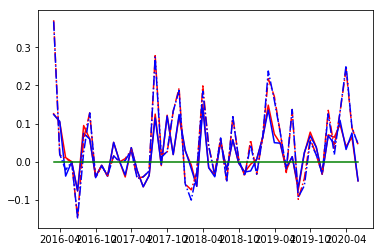

In [192]:
plt.figure()
plt.plot(tmp_mth.index,tmp_mth[('r_t1','mean')],color='r')
plt.plot(tmp_mth.index,tmp_mth[('r_t1','median')],color='b')

plt.plot(tmp_mth.index,tmp_mth[('r_t2','mean')],color='r',linestyle='-.')
plt.plot(tmp_mth.index,tmp_mth[('r_t2','median')],color='b',linestyle='-.')

plt.plot(tmp_mth.index,[0]*len(tmp_mth),color='g')

In [193]:
tmp_q = tmp_day[[('r_t1','mean'),('r_t1','median'),('r_t2','mean'),('r_t2','median')]].resample('Q').apply(lambda x:((1+x).prod(axis=0)-1))
tmp_y = tmp_day[[('r_t1','mean'),('r_t1','median'),('r_t2','mean'),('r_t2','median')]].resample('A').apply(lambda x:((1+x).prod(axis=0)-1))
tmp_q
tmp_q.agg(['mean','median','std'])

tmp_y
tmp_y.agg(['mean','median','std'])


r_t1                r_t2          
                mean    median      mean    median
date                                              
2016-03-31  0.247114  0.247518  0.438840  0.436374
2016-06-30 -0.067431 -0.112426 -0.139706 -0.165436
2016-09-30  0.118659  0.096029  0.148397  0.108783
2016-12-31  0.001122  0.001122 -0.033349 -0.033349
2017-03-31 -0.005814 -0.000715  0.036825  0.031651
2017-06-30 -0.120938 -0.120938 -0.107999 -0.107999
2017-09-30  0.256493  0.244472  0.362473  0.350423
2017-12-31  0.175842  0.185357  0.288426  0.281825
2018-03-31  0.061483  0.040446  0.071836  0.028468
2018-06-30 -0.001577 -0.006188  0.070271  0.064543
2018-09-30  0.029390  0.029390  0.068271  0.068271
2018-12-31 -0.034302 -0.050625 -0.023244 -0.035053
2019-03-31  0.321574  0.277391  0.558388  0.572737
2019-06-30  0.034360  0.041562  0.192588  0.204738
2019-09-30  0.017094  0.017599 -0.089437 -0.107754
2019-12-31  0.075207  0.073035  0.121721  0.111426
2020-03-31  0.203152  0.185670  0.465891  0.459156
2020-06-30  0.005308  0.016320  0.131670  0.132885

r_t1                r_t2          
            mean    median      mean    median
mean    0.073152  0.064723  0.142326  0.133427
median  0.031875  0.034918  0.096779  0.088527
std     0.121849  0.118974  0.205742  0.211228

r_t1                r_t2          
                mean    median      mean    median
date                                              
2016-12-31  0.302483  0.214957  0.374109  0.284822
2017-12-31  0.291209  0.295817  0.623522  0.592929
2018-12-31  0.053533  0.010513  0.196987  0.128596
2019-12-31  0.494915  0.452778  0.898283  0.878943
2020-12-31  0.209538  0.205020  0.658904  0.653055

r_t1                r_t2          
            mean    median      mean    median
mean    0.270336  0.235817  0.550361  0.507669
median  0.291209  0.214957  0.623522  0.592929
std     0.160160  0.160326  0.271165  0.299837

In [207]:
%time date = df.index[mask_date].get_level_values('date').drop_duplicates()
len(date)
date

Wall time: 216 ms


1072

DatetimeIndex(['2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07',
               '2016-01-08', '2016-01-11', '2016-01-12', '2016-01-13',
               '2016-01-14', '2016-01-15',
               ...
               '2020-05-18', '2020-05-19', '2020-05-20', '2020-05-21',
               '2020-05-22', '2020-05-25', '2020-05-26', '2020-05-27',
               '2020-05-28', '2020-05-29'],
              dtype='datetime64[ns]', name='date', length=1072, freq=None)

In [208]:
day_r = tmp_day.reindex(date).fillna(0)
day_v = (day_r[[('r_t1','mean'),('r_t1','median'),('r_t2','mean'),('r_t2','median')]]+1).cumprod()


r_t1                r_t2          
                mean    median      mean    median
date                                              
2020-04-29  3.257480  2.831838  7.704375  6.573029
2020-04-30  3.383509  2.941400  8.080049  6.893536
2020-05-06  3.461406  3.009118  8.415493  7.179722
2020-05-07  3.461406  3.009118  8.415493  7.179722
2020-05-08  3.375563  2.934492  8.516479  7.265878
2020-05-11  3.445888  2.995628  8.658421  7.386977
2020-05-12  3.445888  2.995628  8.658421  7.386977
2020-05-13  3.445888  2.995628  8.658421  7.386977
2020-05-14  3.377090  2.935819  8.868869  7.566522
2020-05-15  3.156089  2.743696  8.321085  7.099177
2020-05-18  3.156089  2.743696  8.321085  7.099177
2020-05-19  3.233756  2.811214  8.767855  7.480341
2020-05-20  3.233756  2.811214  8.767855  7.480341
2020-05-21  3.109532  2.703222  8.345501  7.120008
2020-05-22  3.119758  2.712112  8.418210  7.182040
2020-05-25  3.203707  2.785092  8.409122  7.174286
2020-05-26  3.203707  2.785092  8.409122  7.174286
2020-05-27  3.203707  2.785092  8.409122  7.174286
2020-05-28  3.203707  2.785092  8.409122  7.174286
2020-05-29  3.203707  2.785092  8.409122  7.174286

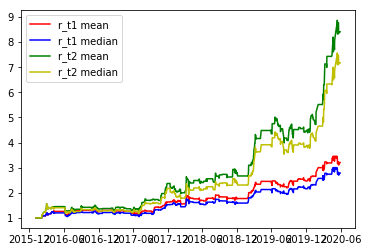

In [217]:
f= plt.figure()
for col,c in zip(day_v.columns,['r','b','g','y']):
    plt.plot(day_v.index,day_v[col],color=c,label=' '.join(col))
plt.legend(loc='upper left')
f.savefig('val_curve.png')
    
    
# plt.plot(day_v.index,day_v[('r_t1','mean')],color='r')
# plt.plot(day_v.index,day_v[('r_t1','median')],color='b')

# plt.plot(day_v.index,day_v[('r_t2','mean')],color='r',linestyle='-.')
# plt.plot(day_v.index,day_v[('r_t2','median')],color='b',linestyle='-.')

# # plt.plot(day_v.index,[0]*len(tmp_mth),color='g')


In [218]:
day_v.to_excel('val_curve.xlsx')